Code authored by Rakshatha Vasudev

1.Importing required libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, r2_score

2.Loading and analyzing dataset

In [19]:
# Loading  dataset
file_path = "../data/TASK-ML-INTERN.csv"
df = pd.read_csv(file_path)
print(df.head())
print(df.shape)

           hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.701995  0.696077   
2  0.333882  0.330841  0.328925  ...  0.683054  0.669286  0.663179  0.676165   
3  0.458194  0.427737  0.415360  ...  0.742782  0.730801  0.736787  0.730044   
4  0.458229  0.440782  0.426193  ...  0.770227  0.773013  0.761431  0.763488   

        443       444       445 

3.Dataset summary

In [20]:
# Inspect dataset
print(df.info())
print(df.describe())
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 450 entries, hsi_id to vomitoxin_ppb
dtypes: float64(449), object(1)
memory usage: 1.7+ MB
None
                0           1           2           3           4           5  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.443118    0.440761    0.433814    0.426122    0.418990    0.412432   
std      0.044719    0.045520    0.045764    0.046070    0.045405    0.044727   
min      0.311182    0.295321    0.284064    0.282054    0.296702    0.286860   
25%      0.410456    0.404310    0.397038    0.389029    0.382102    0.377157   
50%      0.449105    0.442651    0.434215    0.425074    0.417075    0.411872   
75%      0.480245    0.478822    0.473158    0.464947    0.459232    0.452198   
max      0.556287    0.530168    0.528774    0.533202    0.511909    0.501786   

                6           7           8           9  ...         439  \
count  500.000000  

4.EDA and preprocessing

In [21]:
# Handle missing values (Impute with mean for numeric columns only)
numeric_columns = df.select_dtypes(include=np.number).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [22]:
# Identify potential outliers using Z-score
z_scores = (df.iloc[:, 1:] - df.iloc[:, 1:].mean()) / df.iloc[:, 1:].std()
outliers = (np.abs(z_scores) > 3).sum()
print(f"Outliers per spectral band:\n{outliers}")

Outliers per spectral band:
0                0
1                1
2                1
3                1
4                0
                ..
444              9
445              7
446              4
447              5
vomitoxin_ppb    8
Length: 449, dtype: int64


5. Normalization

In [23]:
# Normalize or Standardize spectral data
scaler = MinMaxScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])
X_scaled = df.iloc[:, 1:]

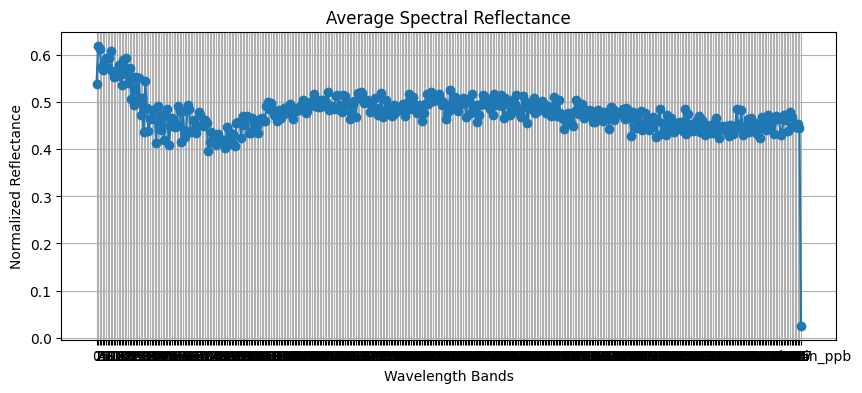

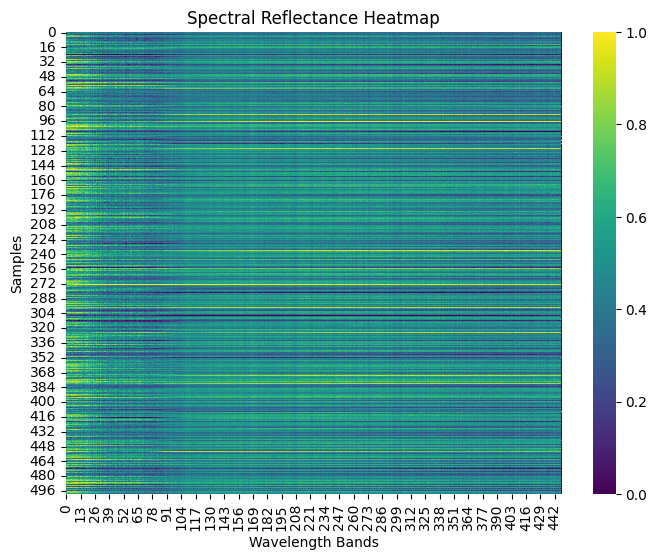

In [35]:

# Visualization: Average spectral reflectance curve
plt.figure(figsize=(10, 4))
plt.plot(df.columns[1:], df.iloc[:, 1:].mean(), marker='o', linestyle='-')
plt.xlabel("Wavelength Bands")
plt.ylabel("Normalized Reflectance")
plt.title("Average Spectral Reflectance")
plt.grid()
plt.show()

# Heatmap: Visualizing spectral patterns across samples
plt.figure(figsize=(8, 6))
sns.heatmap(df.iloc[:, 1:], cmap="viridis", cbar=True)
plt.xlabel("Wavelength Bands")
plt.ylabel("Samples")
plt.title("Spectral Reflectance Heatmap")
plt.show()


The visualizations are complementary:

The line plot summarizes the average behavior of reflectance across wavelengths.

The heatmap provides granular details for individual samples.

The sharp drop in the line plot's final band might warrant further investigation to confirm it isn't a measurement error or data artifact.

6.Dimensionality Reduction

In [24]:
# PCA
pca = PCA(n_components=3)  # Keep the top 3 components for 3D visualization
X_pca = pca.fit_transform(X_scaled)

# Variance Explained by PCA components
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Top 3 Components: {explained_variance}")

Explained Variance by Top 3 Components: [0.85734282 0.0668519  0.01948314]


First Component (85.73%): Captures the majority of the variance in the dataset.

Second Component (6.69%): Adds a smaller but still meaningful contribution.

Third Component (1.95%): Contributes even less to the overall variance.

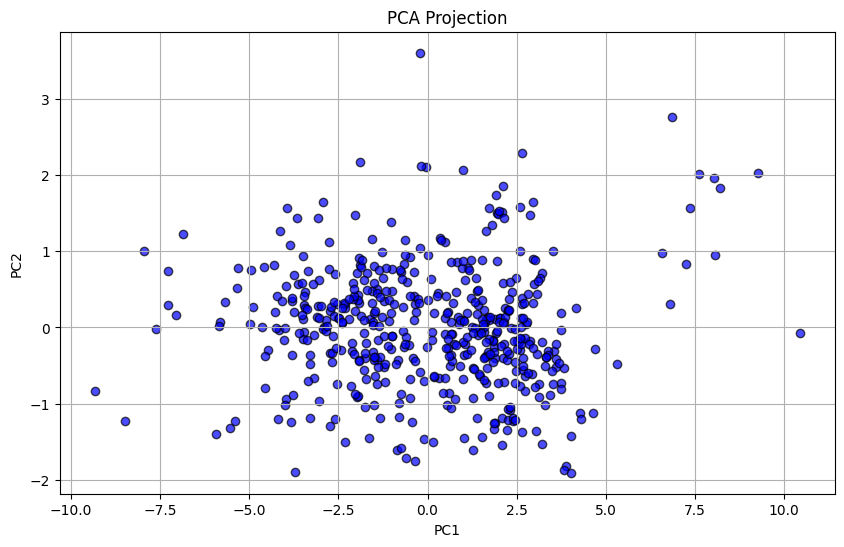

In [33]:
# 2D PCA Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='b', edgecolor='k', alpha=0.7)
plt.title('PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()


The data points are relatively spread out but concentrated near the origin.

No clear clusters are visible, suggesting that the dataset may not have distinct linear separations in these two dimensions.

<ipython-input-36-e82475863ed7>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], palette="viridis", s=50)


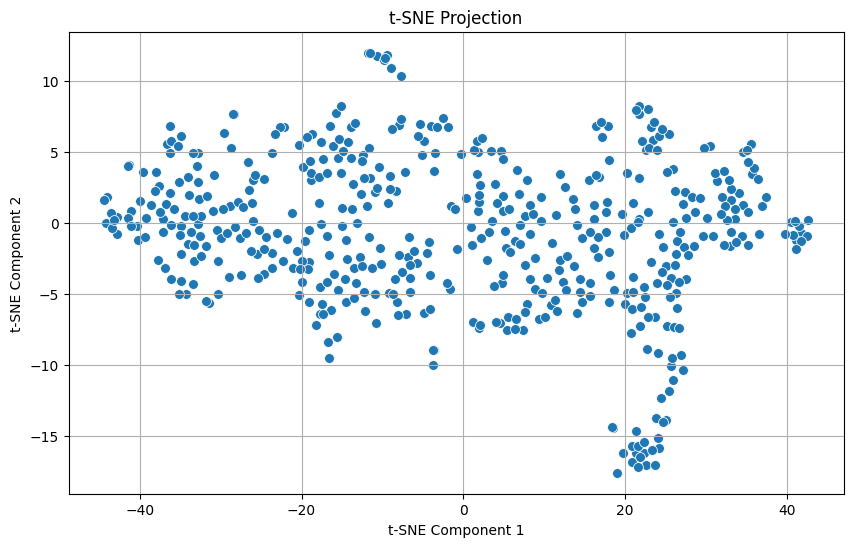

In [36]:

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# t-SNE 2D Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], palette="viridis", s=50)
plt.title('t-SNE Projection')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

The data points exhibit more distinct groupings compared to PCA, indicating potential clusters or patterns in the dataset.

t-SNE often reveals non-linear relationships that PCA cannot capture.

7. Train-test split

In [9]:
# Split data into training (80%) and testing (20%) sets
y=df.iloc[:,-1]
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


8.Random Forest as baseline model

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

#Training Random Forest model as the baseline
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)  # Use PCA data for training

# get predictions
y_pred_rf = rf_model.predict(X_test_pca)

#Evaluating the Random Forest model's performance
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R²: {rf_r2}")

Random Forest MAE: 0.015563374045801527
Random Forest R²: 0.8888928683426924


9. Preliminary CNN Model Architecture and training

In [24]:
# Reshape the data for CNN (samples, bands, 1)
X_train_cnn = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_cnn = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

# Build the CNN model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1),padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Model compile
cnn_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Model training
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_data=(X_test_cnn, y_test))

# predictions
y_pred_cnn = cnn_model.predict(X_test_cnn)

# Evaluate the CNN model's performance
cnn_mae = mean_absolute_error(y_test, y_pred_cnn)
cnn_r2 = r2_score(y_test, y_pred_cnn)

print(f"CNN MAE: {cnn_mae}")
print(f"CNN R²: {cnn_r2}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0160 - mae: 0.0869 - val_loss: 0.0122 - val_mae: 0.0628
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0438 - val_loss: 0.0076 - val_mae: 0.0386
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - mae: 0.0325 - val_loss: 0.0070 - val_mae: 0.0351
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0033 - mae: 0.0283 - val_loss: 0.0068 - val_mae: 0.0415
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 - mae: 0.0314 - val_loss: 0.0060 - val_mae: 0.0345
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038 - mae: 0.0283 - val_loss: 0.0054 - val_mae: 0.0322
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - mae: 0.0272 - val_loss: 0.0052 - val_mae: 0.0331
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - mae: 0.0302 - val_loss: 0.0054 - val_mae: 0.0359
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae

10. Hyperparameter tuning for defined CNN model using GridSearch

In [45]:
# build the CNN model
def build_model(filters=32, kernel_size=3, learning_rate=0.001):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train_cnn.shape[1], 1), padding='same'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model


# Defining the parameter grid for hyperparameter tuning
param_grid = {
    'model__filters': [32, 64],  # Number of filters in the Conv1D layer
    'model__kernel_size': [3, 5],  # Kernel size for Conv1D
    'model__learning_rate': [0.001, 0.01],  # Learning rate for Adam optimizer
    'batch_size': [32, 64],  # Batch size
    'epochs': [50, 100]  # Number of epochs
}

# Wrapping the model with KerasRegressor for GridSearchCV
cnn_model = KerasRegressor(model=build_model, verbose=0)


#GridSearchCV to search for the best parameters
grid_search = GridSearchCV(estimator=cnn_model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_absolute_error', verbose=2)
grid_search.fit(X_train_cnn, y_train)

# Get the best parameters and evaluate the model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


best_cnn_model = grid_search.best_estimator_

y_pred_best_cnn = best_cnn_model.predict(X_test_cnn)

# Evaluate the best model's performance
best_cnn_mae = mean_absolute_error(y_test, y_pred_best_cnn)
best_cnn_r2 = r2_score(y_test, y_pred_best_cnn)

print(f"Best CNN MAE: {best_cnn_mae}")
print(f"Best CNN R²: {best_cnn_r2}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters: {'batch_size': 64, 'epochs': 100, 'model__filters': 32, 'model__kernel_size': 5, 'model__learning_rate': 0.01}
Best CNN MAE: 0.0256726129968288
Best CNN R²: 0.7210440568764666


The model best parameters (filters, kernel_size and learning rate) trained with 32 batch size and for 100 epochs achieved better performance than the baseline model with efficient hyperparametr tuning

Predicted values analysis

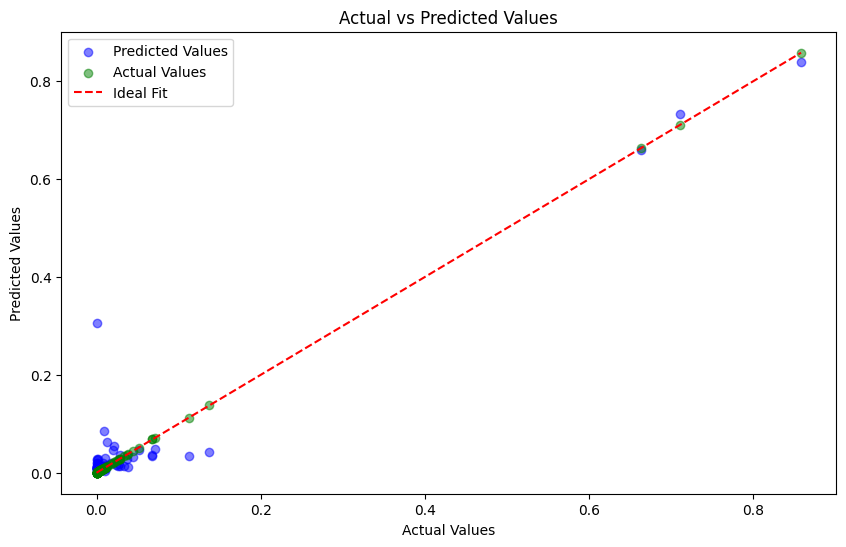

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best_cnn, alpha=0.5, color='blue', label="Predicted Values")
plt.scatter(y_test, y_test, alpha=0.5, color='green', label="Actual Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()

In [ ]:
#code authored by Rakshatha Vasudev